In [15]:
import numpy as np
import glob
import os

root_dir='./lspet_dataset'

unsorted_image_arr = np.array(glob.glob(os.path.join(root_dir, 'images/*.jpg')))
image_nums_arr = np.array([float(s.rsplit('/')[-1][2:-4]) for s in unsorted_image_arr])
image_arr = unsorted_image_arr[np.argsort(image_nums_arr)]

#images need to be sorted for some reason i.e. some images are disordered using glob 
#(e.g. im00020.jpg, im00040.jpg, im00060.jpg, im00080.jpg)

#for example im00020.jpg index=19
print('unsorted image name array: ', unsorted_image_arr[19])
print('sorted image name array: ', image_arr[19])

unsorted image name array:  ./lspet_dataset/images/im00021.jpg
sorted image name array:  ./lspet_dataset/images/im00020.jpg


In [16]:
import scipy.io

mat_arr = scipy.io.loadmat(os.path.join(root_dir, 'joints.mat'))['joints']

print('original kpts shape: ', np.shape(mat_arr))

kptsa = mat_arr.transpose([2, 1, 0])

print('kptsa shape: ', np.shape(kptsa))

kptsb = mat_arr.transpose([2, 0, 1])

print('kptsb shape: ', np.shape(kptsb))


original kpts shape:  (14, 3, 10000)
kptsa shape:  (10000, 3, 14)
kptsb shape:  (10000, 14, 3)


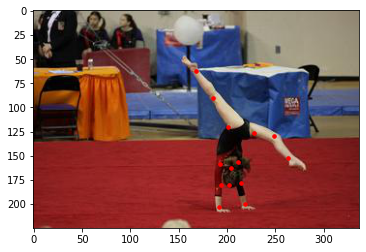

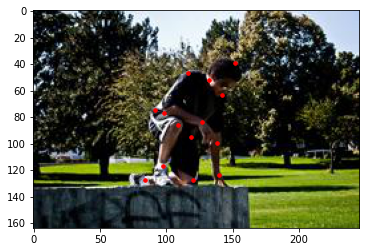

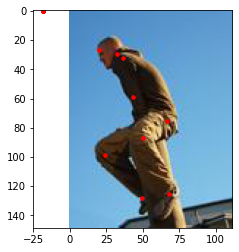

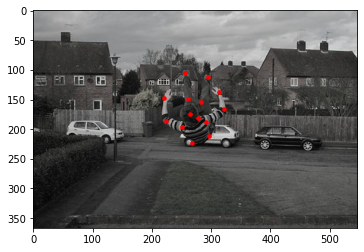

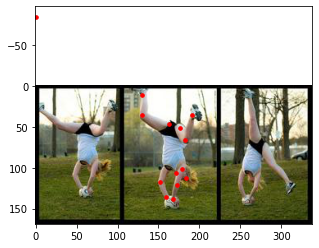

In [17]:
import matplotlib.pyplot as plt
from skimage import io

def visualise_keypoints(image, keypoints):
    plt.figure()
    plt.imshow(io.imread(image))
    plt.scatter(keypoints[:,0], keypoints[:,1], s=50, marker='.', c='r') 

randimgs=np.random.rand(5)

for i in range(len(randimgs)):
    imageno = int(randimgs[i]*10000)
    visualise_keypoints(image_arr[imageno],kptsb[imageno])
    
# joint names:
# 0 = Right Ankle
# 1 = Right Knee
# 2 = Right Hip
# 3 = Left  Hip
# 4 = Left  Knee
# 5 = Left  Ankle
# 6 = Right Wrist
# 7 = Right Elbow
# 8 = Right Shoulder
# 9 = Left  Shoulder
# 10 = Left  Elbow
# 11 = Left  Wrist
# 12 = Neck
# 13 = Head  Top


In [18]:
## calculate image and keypoint properties; center and scale

from PIL import Image

centers = []

for idx in range(len(randimgs)):
    im = Image.open(image_arr[idx])
    w = im.size[0]
    h = im.size[1]
    
    ## calculate person centerpoints:
    # between max and min keypoint x values
    center_x = (kptsa[idx][0][kptsa[idx][0] < w].max() + kptsa[idx][0][kptsa[idx][0] > 0].min()) / 2
    # between max and min keypoint y values
    center_y = (kptsa[idx][1][kptsa[idx][1] < h].max() + kptsa[idx][1][kptsa[idx][1] > 0].min()) / 2
    centers.append([center_x, center_y])

print ('keypoints center: ', centers)


keypoints center:  [[81.13368251615368, 54.297577681588166], [89.18972605571943, 94.53899109825367], [122.12717464065355, 167.5307003139321], [67.55294117647058, 128.24705882352941], [111.88877093286078, 89.24682431223894]]


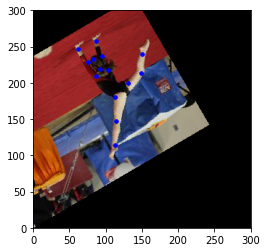

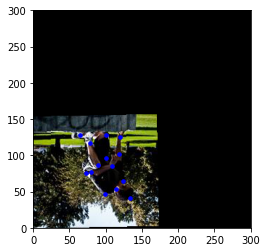

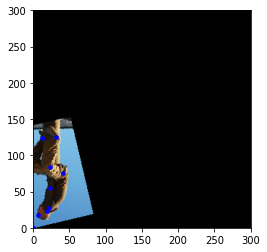

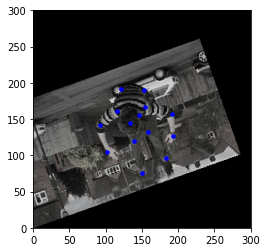

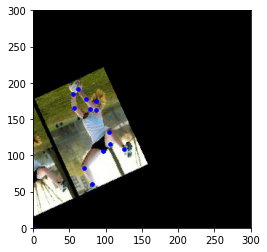

In [19]:
import math

def random_crop_rot(idx, image, keypoints):

    """Randomly crops and rotate the image and keypoints (data augmentation).

    Args:
        idx    (numpy.ndarray):       Image index.
        image    (numpy.ndarray):     Image to be transformed.
        keypoints (numpy.ndarray):    Keypoints to be transformed.

    Returns:
        numpy.ndarray: Transformed image.
        list:          Transformed keypoints.
    """
    
    image = Image.open(image[idx])
    w = image.size[0]
    h = image.size[1]
    
    rands=np.random.rand(5)
    pos=keypoints.transpose([0, 2, 1])
    left = int(rands[0]*(pos[idx][0][pos[idx][0] > 0].min())) - 10
    top = int(rands[1]*(pos[idx][1][pos[idx][1] > 0].min())) - 10
    right = int(pos[idx][0][pos[idx][0] < w].max() + rands[2]*(w - pos[idx][0][pos[idx][0] < w].max())) + 10
    bottom = int(pos[idx][1][pos[idx][1] < h].max() + rands[3]*(h - pos[idx][1][pos[idx][1] < h].max())) + 10
    
    image = image.crop((left, top, right, bottom))
    
    plt.figure()
    #plt.imshow(image)
        
    keypoints=keypoints[idx]

    kptpos = []
    kptposx = []
    kptposy = []
    for j in range(14):
        if keypoints[j][0] > 0:
            kptposx.append(keypoints[j][0]-left)
        else:
            kptposx.append(0)
        if keypoints[j][1] > 0:
            kptposy.append(keypoints[j][1]-top)
        else:
            kptposy.append(0)
    
    kptposx=np.array(kptposx)
    kptposy=np.array(kptposy)
    updatedkptpos=(kptposx, kptposy, np.zeros(14))
       
    #plt.scatter(keypoints[:,0], keypoints[:,1], s=50, marker='.', c='r')
    
    #affine transformation of keypoint using a rotation matrix (R)
    sx = 1
    sy = 1
    
    angle = math.radians(rands[4]*40)

    cos_theta = math.cos(angle)
    sin_theta = math.sin(angle)
    
    R = np.array([[cos_theta, sin_theta, 0],
                  [-sin_theta, cos_theta, 0],
                  [0, 0, 1]])
    
    updatedkptpos=np.matmul(np.linalg.inv(R), updatedkptpos)
    
    img_transformed = image.transform((500, 500), Image.AFFINE, data=R.flatten()[:6])
    
    plt.ylim(0, 300)
    plt.xlim(0, 300)
    plt.imshow(np.asarray(img_transformed))
    
    plt.scatter(updatedkptpos[0], updatedkptpos[1], s=50, marker='.', c='b')
    
    
for i in range(len(randimgs)):
    imageno = int(randimgs[i]*10000)
    random_crop_rot(imageno, image_arr, kptsb)

